# Predicting the Sale Price of Bulldozers using ML

In this notebook, we're going to go through an example ML project with the goal of predicting the sale price of Bulldozers
## 1. Problem definition
> How well can we predict the future sale price of a Bulldozers, given its characteristics and previous examples of how much similar Bulldozers have been sold for?

## 2. Data

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and prdicted auction prices. See more (https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation)

**Note:*** The goal for most regression evaluation metrics is to minimizee the error. For example, our goal for this project will be to build a ML model which minimises RMSLE.


## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary in porject folder: .\Data Dictionary.xlsx


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [43]:
# Import training and validation sets
df = pd.read_csv('../bluebook-for-bulldozers/TrainAndValid.csv')

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [45]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

<AxesSubplot:ylabel='Frequency'>

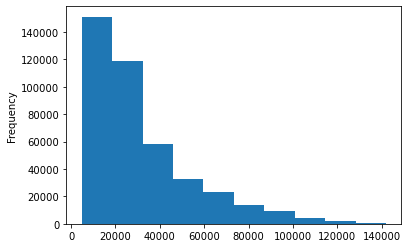

In [46]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time $ date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameter.

In [47]:
# Import data again but this time parse dates
df = pd.read_csv('../bluebook-for-bulldozers/TrainAndValid.csv',
                    parse_dates=['saledate'])

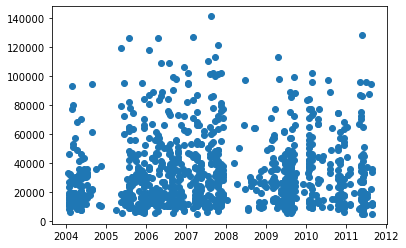

In [48]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

### Sort DataFrame by saledata

When working with time series data, it's a good idea to sort it by date.

In [49]:
# Sort DataFrame in date order
df = df.sort_values(by=['saledate'], ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make a copy of the original DataFrame
We make a copy of the original dataframe so when we mnipulate the copy, we've still got our original dataframe

In [50]:
# make a copy
df_tmp = df.copy()

## Add DateTime parameters for saledate column

In [51]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [52]:
# Now we've enriched our DataFrame with date time features, we can remove saledate
df_tmp = df_tmp.drop('saledate', axis=1)

In [53]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've dont enought EDA (we could always do more) but let's start to do some model-driven EDA.


In [54]:
# Let's build a ML model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42) # random_state equals to random.seed()

model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

ValueError: could not convert string to float: 'Low'

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into Pandas categories.
We can check the different datatypes compatible with pandas here:

https://pandas.pydata.org/docs/reference/general_utility_functions.html#data-types-related-functionality



In [55]:
pd.api.types.is_string_dtype(df_tmp['UsageBand'])

True

In [56]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [57]:
# If you're wondering what df.items() does, here's an example
random_dict = {'key1': 'hello',
                'key2': 'world!'}

for key, value in random_dict.items():
    print(f'this is a key: {key}',
            f'this is a value: {value}')

this is a key: key1 this is a value: hello
this is a key: key2 this is a value: world!


In [58]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [19]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [59]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [60]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

### Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.abs
But we still have a bunch of missing data...

In [61]:
# Check missing values
df_tmp.isnull().sum() / len (df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed

In [62]:
# Export current tmp dataframe
df_tmp.to_csv('../bluebook-for-bulldozers/train_tmp.csv', index=False)

In [64]:
# Import preporcessed data
df_tmp = pd.read_csv('../bluebook-for-bulldozers/train_tmp.csv', low_memory=False)

## Filling missing values

### Fill numeric missing values first

In [65]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)
        

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [66]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)


auctioneerID
MachineHoursCurrentMeter


In [67]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            # Add a binary column which tells us if the data was misssing
            df_tmp[label + '_is_missing'] = pd.isnull(content)
            # Filling missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

auctioneerID
MachineHoursCurrentMeter


In [68]:
# Demo why median is more robust than mean
hundrends = np.full((1000,), 100)
hundrends_billion = np.append(hundrends, 10000000000)
np.mean(hundrends), np.mean(hundrends_billion), np.median(hundrends), np.median(hundrends_billion)

(100.0, 9990109.89010989, 100.0, 100.0)

In [69]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [70]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [71]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorcal variables into numbers

In [72]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [73]:
# Turn categorical variable into numbers an fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label + '_is_missing'] = pd.isnull(content)
        # Turn categories into numbers ad add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [74]:
pd.Categorical(df_tmp['state']).codes + 1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [75]:
pd.Categorical(df_tmp['UsageBand']).codes

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [76]:
df_tmp.isna().sum()[:10]

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
dtype: int64

### Now that all data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model


In [77]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                                random_state=42)

# Fit the model
model.fit(df_tmp.drop('SalePrice', axis=1), df_tmp["SalePrice"])

Wall time: 1min 52s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [78]:
# Score the model
model.score(df_tmp.drop('SalePrice', axis=1), df_tmp['SalePrice'])

0.9875516841918182

** Question: ** Why doesn't the above metric hold water? (why isn't the metric  rliable)

### Splitting data int otrain/validation sets

In [79]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [80]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [81]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [131]:
# Split data into X & y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an avaluatoin function

In [83]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between predictions and true labels.
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels 
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
                'Valid MAE': mean_absolute_error(y_valid, val_preds),
                'Training RMSLE': rmsle(y_train, train_preds),
                'Valid RMSLE': rmsle(y_valid, val_preds),
                'Training R^2': r2_score(y_train, train_preds),
                'Valid R&2': r2_score(y_valid, val_preds)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

In [84]:
%%time
# This takes far too long for experimenting, so we cut our dataset with max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

model.fit(X_train, y_train)

Wall time: 5.35 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [85]:
show_scores(model)

{'Training MAE': 5561.162486855717,
 'Valid MAE': 7175.539684610732,
 'Training RMSLE': 0.2577413666148792,
 'Valid RMSLE': 0.29362620003305046,
 'Training R^2': 0.8606724557441926,
 'Valid R&2': 0.8320287347586728}

## Hyperparameters tuning wiht RAndomizedSearchCV

In [87]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor import RandomizedSearchCV
rf_grid = {'n_estimators': np.arange(10, 100, 10),
            'max_depth': [None, 3, 5, 10],
            'min_samples_split': np.arange(2, 20, 2),
            'min_samples_leaf': np.arange(1, 20, 2),
            'max_features': [0.5, 1, 'sqrt', 'auto'],
            'max_samples': [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                                param_distributions=rf_grid,
                                n_iter=5,
                                cv=5,
                                verbose=True)
# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

ation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\joblib\parallel.py", line 1054, in __call__
    self.retrieve()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\joblib\parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\joblib\_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\concurrent\futures\_base.py", line 445, in result
    return self.__get_result()
  File "C:\ProgramData\Anaconda3\envs\tf\lib\concurrent\futures\_base.py", line 390, in __get_result
    raise self._exception
joblib.externals.loky.process_executor.Termin

KeyboardInterrupt: 

In [88]:
# Find the best model hyperparameters
rs_model.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [48]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 6364.475450726353,
 'Valid MAE': 7962.335114464912,
 'Training RMSLE': 0.2867283695669576,
 'Valid RMSLE': 0.3162400309612427,
 'Training R^2': 0.816851050534233,
 'Valid R&2': 0.7849018922185527}

## Train a model with the best hyperparameters
NOTE: These were found after 100 iterations of RandomizedSearchCV

In [89]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_split=12,
                                    min_samples_leaf=3,
                                    max_features=1,
                                    n_jobs=-1,
                                    max_depth=None,
                                    max_samples=None,
                                    random_state=42) # Random state for reproducable results 
# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 3.73 s


RandomForestRegressor(max_features=1, min_samples_leaf=3, min_samples_split=12,
                      n_estimators=40, n_jobs=-1, random_state=42)

In [90]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 7103.62281536997,
 'Valid MAE': 10114.269979183971,
 'Training RMSLE': 0.3267398032560023,
 'Valid RMSLE': 0.4048856069452835,
 'Training R^2': 0.7949929996161365,
 'Valid R&2': 0.6983560799120782}

In [91]:
# Scores on rs_model (only trained on 10000 examples)
show_scores(rs_model)

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Make predictions on test data


In [117]:
# Import the test data
df_test = pd.read_csv("../bluebook-for-bulldozers/Test.csv",
                    parse_dates=['saledate'])

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [118]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [119]:
def preprocess_data(df):
    '''
    Performs transformations on df and returns transformed df
    '''
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear

    df.drop('saledate', axis=1, inplace=True)

    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add binary column to indicate whether sample had missing value
                df[label + '_is_missing'] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())

        # Filled categorical missing data and turned categorical into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label + "_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because Pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes + 1 
    return df

In [120]:
# Process the test data
df_test = preprocess_data(df_test)

In [121]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: X has 101 features, but DecisionTreeRegressor is expecting 102 features as input.

In [122]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [123]:
# Manually adjust df_test to have autioneerID_is_missing column
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


### Finally now our test datafaame has the same features as our trainning dataframe, we can make predictions!

In [124]:
# Make predictions on the test data 
test_preds = ideal_model.predict(df_test)

### Finally now ort test datafame has the same features as our training dataframe, we can make predictions!

In [125]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

### We've made some predictions but they're not in the same format KAggle is asking for:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview

In [126]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,22992.668430
1,1227844,34346.518399
2,1227847,36772.492108
3,1227848,38205.853828
4,1227863,33009.006997
...,...,...
12452,6643171,39550.026383
12453,6643173,32344.105059
12454,6643184,31466.933751
12455,6643186,34342.883143


In [127]:
# Export predicitons data
df_preds.to_csv('./test_predicitons.csv', index=False)

###  Feature importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

In [128]:
ideal_model.feature_importances_

array([3.39741891e-02, 3.17969469e-02, 4.84040910e-02, 5.48225360e-03,
       7.71068225e-03, 8.21521597e-02, 1.02997745e-02, 5.65727314e-03,
       4.81870311e-02, 3.85976605e-02, 6.84686302e-02, 1.32931979e-02,
       2.09550098e-02, 5.12392642e-02, 4.23176001e-02, 9.18879796e-03,
       8.99914046e-03, 4.98543175e-03, 5.68508469e-03, 4.02784694e-02,
       8.99608745e-03, 3.26519620e-03, 1.29634662e-02, 5.89825658e-03,
       6.86624029e-03, 4.13417419e-03, 2.73246699e-03, 2.55742031e-03,
       4.58214530e-03, 4.75213450e-03, 8.10882665e-03, 5.44908697e-03,
       9.43930501e-03, 8.79856443e-04, 5.75618844e-03, 4.88474484e-03,
       4.63795353e-03, 1.04758071e-02, 1.93461828e-02, 2.15778950e-03,
       9.60681746e-03, 3.76858736e-03, 7.93206808e-03, 3.56284929e-03,
       3.43905113e-03, 4.65564640e-03, 3.10163472e-03, 8.25475617e-03,
       7.93056344e-03, 1.43005989e-03, 1.78549684e-03, 1.94417861e-02,
       6.36132142e-03, 7.76104208e-03, 6.17344209e-03, 9.95507975e-03,
      

In [133]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_is_missing', 'Stick_Length_is_missing',
       'Thumb_is_missing', 'Pattern_Changer_is_missing',
       'Grouser_Type_is_missing', 'Backhoe_Mounting_is_missing',
       'Blade_Type_is_missing', 'Travel_Controls_is_missing',
       'Differential_Type_is_missing', 'Steering_Controls_is_missing'],
      dtype='object', length=102)

In [139]:
# Helper funciton for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
    .sort_values("feature_importances", ascending=False)
    .reset_index(drop=True))

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

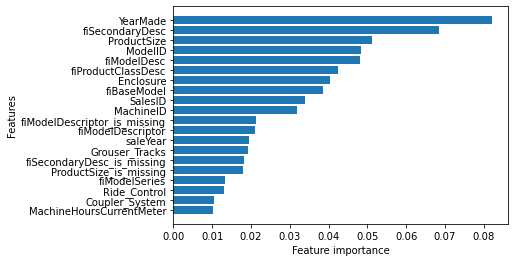

In [140]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [141]:
X_train['ProductSize'].value_counts()

0    210775
4     62274
3     49678
6     26494
5     24840
2     20975
1      6089
Name: ProductSize, dtype: int64

In [142]:
df['Enclosure'].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

** Question to finish ** Why might knowing the ffeature importances of a trained ML model be helpful?

** Final challenge: ** What other ML models could you try on our dataset?

Check out the regression section of this map, or try to look at something like CatBoost.ai of XGBost.ai